In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Libraries</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Intro</p>

This Kaggle notebook is aimed at providing a comprehensive exploratory data analysis (EDA) for the given dataset, with the ultimate goal of making informed decisions and recommendations before diving into modeling. 
>Through this EDA, we will gain a deeper understanding of the data structure, missing values, relationships between variables, and any patterns or anomalies that could impact our modeling process. By performing a thorough EDA, we can identify potential roadblocks and make necessary pre-processing decisions that will improve the performance and accuracy of our models. So, buckle up, and let's embark on this journey of discovering insights and valuable information from the data to drive better modeling decisions.**

**Disclaimer:** You are welcome to use this notebook the way you like. If you feel bored seeing your default jupyter notebook style, you are welcome to use one of the themes I compiled in my [github repo](https://github.com/SergeySakharovskiy/jupyter-themes-css). If you like this kernel or tips, your feedback will encourage me to share more.

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Score Progression</p>

[**Discussions**](https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386687)

In [3]:
exp_log = [
    ['2022-02-14', 'xgb', 'fe_full', 10, .91119, .90962],
    ['2022-02-14', 'xgb', 'fe_full', 20, .91247, np.nan],
    ['2022-02-14', 'xgb', 'fe_without_interaction_ft', 20, .91301, np.nan],
    ['2022-02-14', 'xgb', 'no_fe', 20, .91487, np.nan],
    ['2022-02-14', 'xgb', 'no_fe', 30, .91510, .91123],
    ['2022-02-14', 'xgb', 'fe_fixed_dates', 30, .91629, .91249],
    ['2022-02-14', 'xgb', 'fe_fixed_dates_rm_no_of_previous_cancellations', 30, .91661, .91239],
    ['2022-02-14', 'xgb', 'fe_fixed_dates_ensemble_folds_gt_0.917_colsample_0.67', 30, .91698, .91318],
    ['2022-02-15', 'xgb', '-||- seed 70587', 30, .91718, .91286],
    ['2022-02-15', 'lgbm', '-||- ', 30, .91684, .91222],
    ['2022-02-15', 'lgbm', '-||- only_folds_gt_0.917', 30, .91684, .91195],
    ['2022-02-15', 'lgbm', '-||- only_folds_gt_0.915', 30, .91684, .91209],
    ['2022-02-15', 'xgb_lgbm', 'ensemble xgb_0.91318 & lgbm_0.92220 0.51 | 0.49', 30, .91684, .91286],
    ['2022-02-16', 'lgbm', 'xgb_@_.91222LB_remove_2_worse_ft', 30, 0.91697, .91238],
    ['2022-02-16', 'xgb', 'xgb_@_.91318LB_remove_2_worse_ft', 30, 0.91696, .91332],
    
    
]
progress = pd.DataFrame(exp_log, columns=['date', 'model', 'notes', 'folds', 'AUC_CV', 'AUC_LB'])
progress.tail(10)

,date,model,notes,folds,AUC_CV,AUC_LB
5,2022-02-14,xgb,fe_fixed_dates,30,0.91629,0.91249
6,2022-02-14,xgb,fe_fixed_dates_rm_no_of_previous_cancellations,30,0.91661,0.91239
7,2022-02-14,xgb,fe_fixed_dates_ensemble_folds_gt_0.917_colsamp...,30,0.91698,0.91318
8,2022-02-15,xgb,-||- seed 70587,30,0.91718,0.91286
9,2022-02-15,lgbm,-||-,30,0.91684,0.91222
10,2022-02-15,lgbm,-||- only_folds_gt_0.917,30,0.91684,0.91195
11,2022-02-15,lgbm,-||- only_folds_gt_0.915,30,0.91684,0.91209
12,2022-02-15,xgb_lgbm,ensemble xgb_0.91318 & lgbm_0.92220 0.51 | 0.49,30,0.91684,0.91286
13,2022-02-16,lgbm,xgb_@_.91222LB_remove_2_worse_ft,30,0.91697,0.91238
14,2022-02-16,xgb,xgb_@_.91318LB_remove_2_worse_ft,30,0.91696,0.91332


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Data</p>

**The dataset** for this competition (both train and test) was generated from a deep learning model trained on the [Reservation Cancellation Prediction dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction). The goal is to predict `booking_status` if the booking is going to be cancelled or not.
 
There are 18 independent variables (including `id`):

* `id`: unique identifier of each booking
* `no_of_adults`: Number of adults
* `no_of_children`: Number of Children
* `no_of_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* `no_of_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* `type_of_meal_plan`: Type of meal plan booked by the customer:
* `required_car_parking_space`: Does the customer require a car parking space? (0 - No, 1- Yes)
* `room_type_reserved`: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* `lead_time`: Number of days between the date of booking and the arrival date
* `arrival_year`: Year of arrival date
* `arrival_month`: Month of arrival date
* `arrival_date`: Date of the month
* `market_segment_type`: Market segment designation.
* `repeated_guest`: Is the customer a repeated guest? (0 - No, 1- Yes)
* `no_of_previous_cancellations`: Number of previous bookings that were canceled by the customer prior to the current booking
* `no_of_previous_bookings_not_canceled`: Number of previous bookings not canceled by the customer prior to the current booking
* `avg_price_per_room`: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* `no_of_special_requests`: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

Target varibale:
* `booking_status`: Flag indicating if the booking was canceled or not.


**Metrics**:
* [Area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [4]:
origin = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/train__dataset.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv').drop(columns='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv').drop(columns='id')

In [5]:
print(f'{gld}[INFO] Shapes:'
      f'{gld}\n[+] origin -> {red}{origin.shape}'
      f'{gld}\n[+] train -> {red}{train.shape}'
      f'{gld}\n[+] test -> {red}{test.shape}\n')

print(f'{gld}[INFO] Any missing values:'
      f'{gld}\n[+] origin -> {red}{origin.isna().any().any()}'
      f'{gld}\n[+] train -> {red}{train.isna().any().any()}'
      f'{gld}\n[+] test -> {red}{test.isna().any().any()}')

[INFO] Shapes:
[+] origin -> (18137, 18)
[+] train -> (42100, 18)
[+] test -> (28068, 17)

[INFO] Any missing values:
[+] origin -> False
[+] train -> False
[+] test -> False


### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Train</p>

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='YlOrBr')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
lead_time,42100.000000,103.888029,81.069343,0.000000,37.000000,93.000000,155.000000,443.000000
avg_price_per_room,42100.000000,104.566377,37.139165,0.000000,80.000000,99.450000,123.300000,540.000000
arrival_date,42100.000000,15.902945,8.888582,1.000000,8.000000,16.000000,24.000000,31.000000
arrival_month,42100.000000,7.593539,2.829395,1.000000,6.000000,8.000000,10.000000,12.000000
no_of_previous_bookings_not_canceled,42100.000000,0.175772,1.732121,0.000000,0.000000,0.000000,0.000000,58.000000
no_of_week_nights,42100.000000,2.398005,1.427330,0.000000,1.000000,2.000000,3.000000,17.000000
no_of_weekend_nights,42100.000000,0.884632,0.885693,0.000000,0.000000,1.000000,2.000000,7.000000
room_type_reserved,42100.000000,0.428931,0.832605,0.000000,0.000000,0.000000,1.000000,6.000000
no_of_special_requests,42100.000000,0.571734,0.775041,0.000000,0.000000,0.000000,1.000000,5.000000
market_segment_type,42100.000000,0.728504,0.633529,0.000000,0.000000,1.000000,1.000000,4.000000


### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Test</p>

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
test.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='YlOrBr')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
lead_time,28068.000000,103.845554,81.134833,0.000000,37.000000,92.000000,154.000000,443.000000
avg_price_per_room,28068.000000,104.644460,36.818948,0.000000,80.000000,99.450000,123.300000,540.000000
arrival_date,28068.000000,15.867643,8.934570,1.000000,8.000000,16.000000,24.000000,31.000000
arrival_month,28068.000000,7.583903,2.831911,1.000000,5.000000,8.000000,10.000000,12.000000
no_of_previous_bookings_not_canceled,28068.000000,0.196736,1.941456,0.000000,0.000000,0.000000,0.000000,58.000000
no_of_week_nights,28068.000000,2.387559,1.403213,0.000000,1.000000,2.000000,3.000000,17.000000
no_of_weekend_nights,28068.000000,0.888770,0.878250,0.000000,0.000000,1.000000,2.000000,6.000000
room_type_reserved,28068.000000,0.430668,0.830187,0.000000,0.000000,0.000000,1.000000,6.000000
market_segment_type,28068.000000,0.725951,0.629044,0.000000,0.000000,1.000000,1.000000,4.000000
type_of_meal_plan,28068.000000,0.234110,0.581256,0.000000,0.000000,0.000000,0.000000,3.000000


### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Target Counts</p>

In [8]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df: train or test dataframes
        col_list: a list of the selected categorical variables.
        title_name: 'Train' or 'Test' (default 'Train')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    f, ax = plt.subplots(len(col_list), 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)
    
    s1 = df[col_list].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f', '#ff9752', '#ff9752']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90,frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size':13, 
        'weight': 'bold', 
        'color':'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%',explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', 
                               fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', 
                     fontweight='bold', fontsize=12)

#     plt.title(col_list)
    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col_list, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()    
#     plt.savefig('data/plot_count.png')
    plt.show()

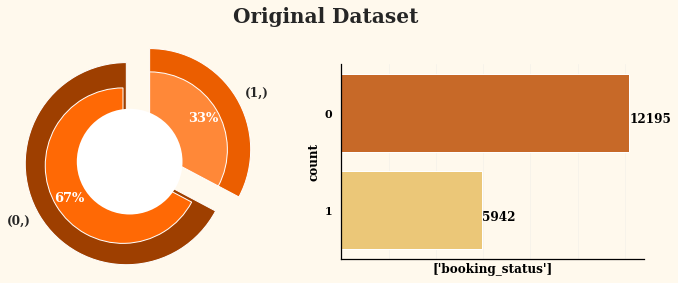

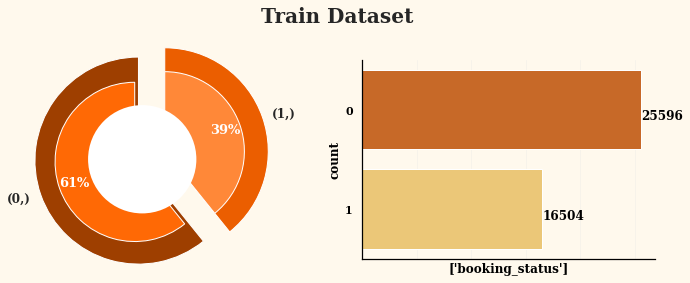

In [9]:
plot_count(origin, ['booking_status'], 'Original')
plot_count(train, ['booking_status'])

**Notes**:

The dataset is disbalanced (does not have equal numbers of classes for target variable). However it seems way much optimistic comparing to the previous playground series.

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Anomalies</p>

**Anomalies** were found when I tried to parse the dates with pd.to_datime() function.

Most of the anomalies are **February 29 days for 2018** (not a leap year). Other examples are **31 days in April and September**.

In [10]:
origin_anom = len(origin.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
train_anom = len(train.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
test_anom = len(test.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
print(f'{gld}[INFO] 2018 was not a leap year, number of Feb, 29:'
      f'{gld}\n[+] origin -> {red}{origin_anom}'
      f'{gld}\n[+] train -> {red}{train_anom}'
      f'{gld}\n[+] test -> {red}{test_anom}\n')


origin['arrival_year_month'] = pd.to_datetime(origin['arrival_year'].astype(str)
                                            +origin['arrival_month'].astype(str), format='%Y%m')
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str)
                                            +train['arrival_month'].astype(str), format='%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str)
                                            +test['arrival_month'].astype(str), format='%Y%m')

origin_total_anom = len(origin.loc[origin.arrival_date > origin.arrival_year_month.dt.days_in_month])
train_total_anom = len(train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month])
test_total_anom = len(test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month])
print(f'{gld}[INFO] Total date anomalies:'
      f'{gld}\n[+] origin -> {red}{origin_total_anom}'
      f'{gld}\n[+] train -> {red}{train_total_anom}'
      f'{gld}\n[+] test -> {red}{test_total_anom}\n')

train.loc[(train.arrival_date > train.arrival_year_month.dt.days_in_month) & train.arrival_month.ne(2)].head(3)

[INFO] 2018 was not a leap year, number of Feb, 29:
[+] origin -> 21
[+] train -> 35
[+] test -> 30

[INFO] Total date anomalies:
[+] origin -> 21
[+] train -> 50
[+] test -> 40



,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_year_month
4696,2,0,0,4,0,0,0,213,2018,9,31,0,0,0,0,118.15,1,1,2018-09-01
4914,2,0,2,2,0,0,0,60,2018,9,31,0,0,0,0,75.00,0,1,2018-09-01
10876,3,0,2,3,0,0,1,44,2018,4,31,1,0,0,0,131.58,0,1,2018-04-01


In [11]:
origin.drop(columns=['arrival_year_month'], inplace=True)
train.drop(columns=['arrival_year_month'], inplace=True)
test.drop(columns=['arrival_year_month'], inplace=True)

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Distributions</p>

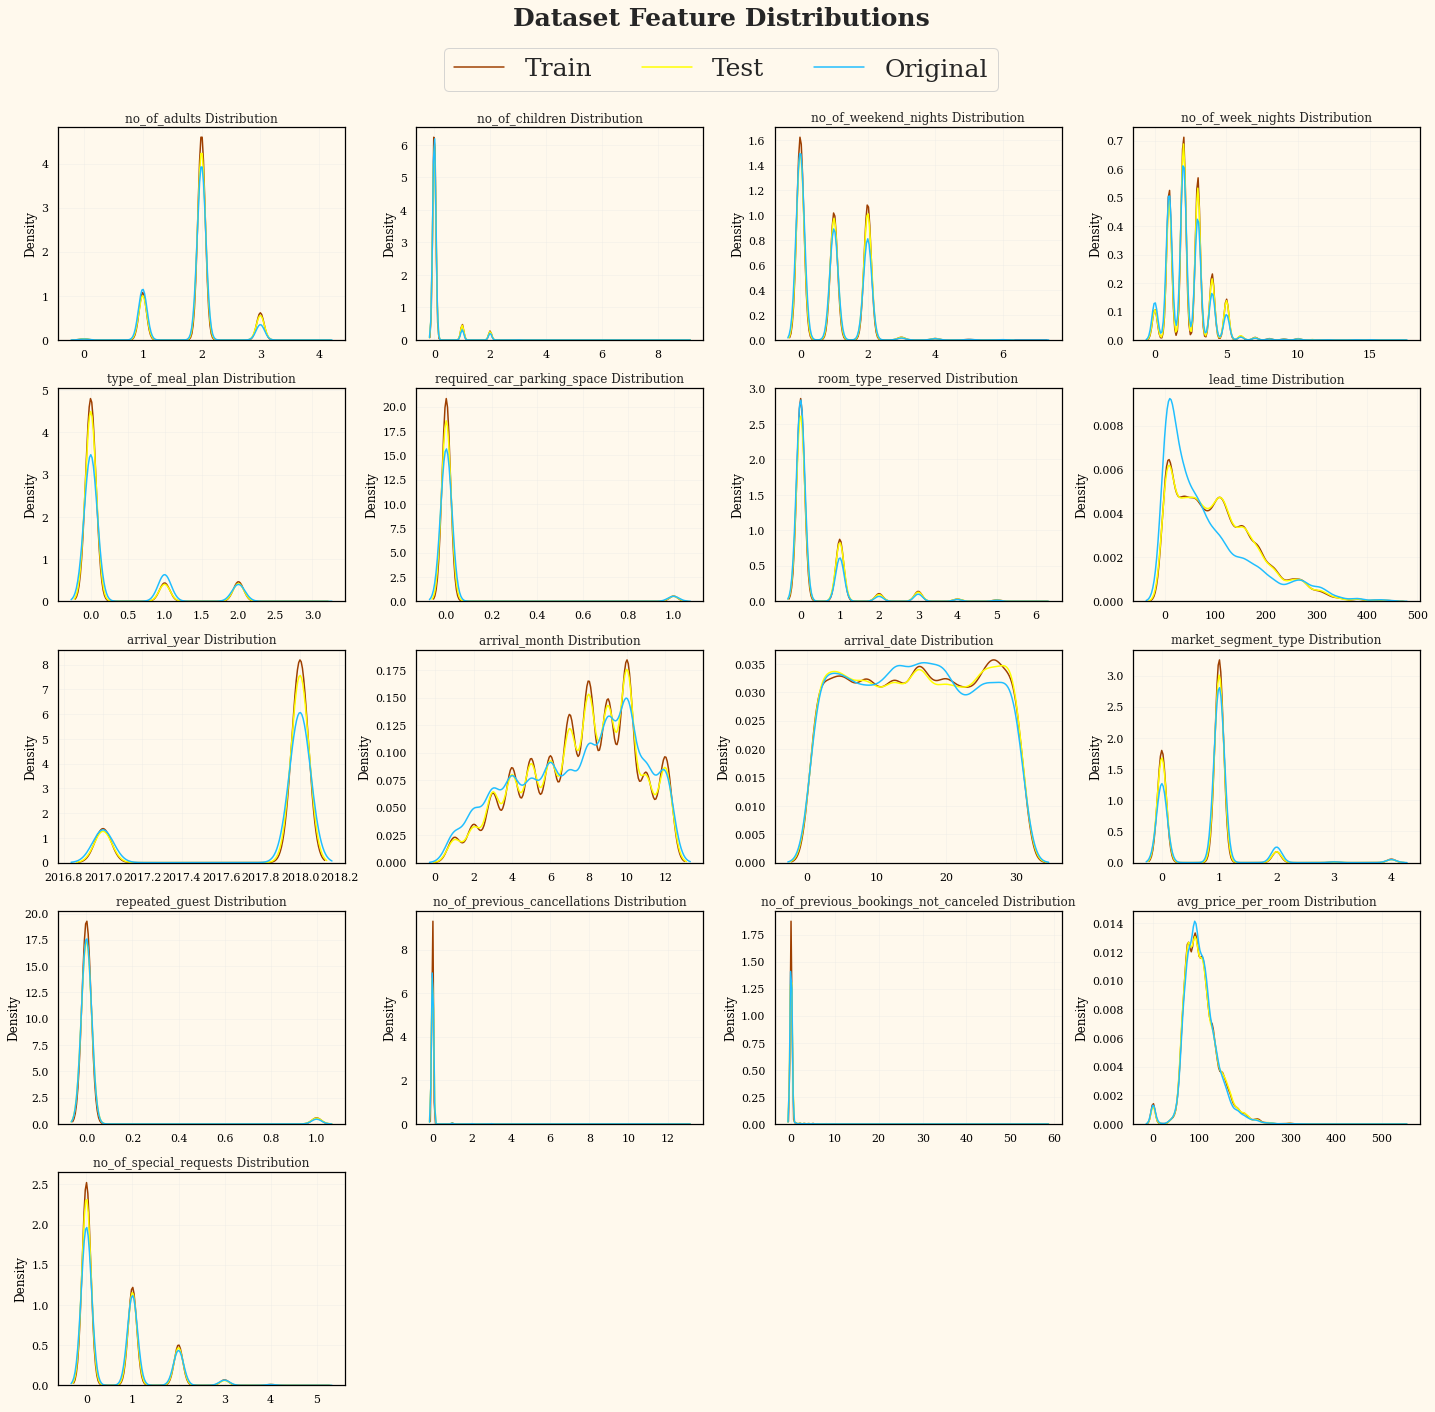

In [12]:
# kudos to @jcaliz
features = test.columns
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
    sns.kdeplot(
        origin[column], label='Original',
        ax=ax[i], color='#20BEFF'
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

A synthetic dataset is a type of dataset created by generating new data that mimics the original data using various techniques. However, it is possible that the synthetic dataset features may not closely follow the original dataset distribution **(our case)**. This can occur due to a variety of factors, such as using a different sampling technique, applying different data transformations, or introducing new features that were not present in the original dataset. When the synthetic dataset features do not closely follow the original dataset distribution, it can affect the performance of machine learning models trained on the origin data, as the models may not accurately capture the underlying patterns and relationships in the original data. Therefore, **it is important to carefully evaluate the quality of both datasets** before using them.

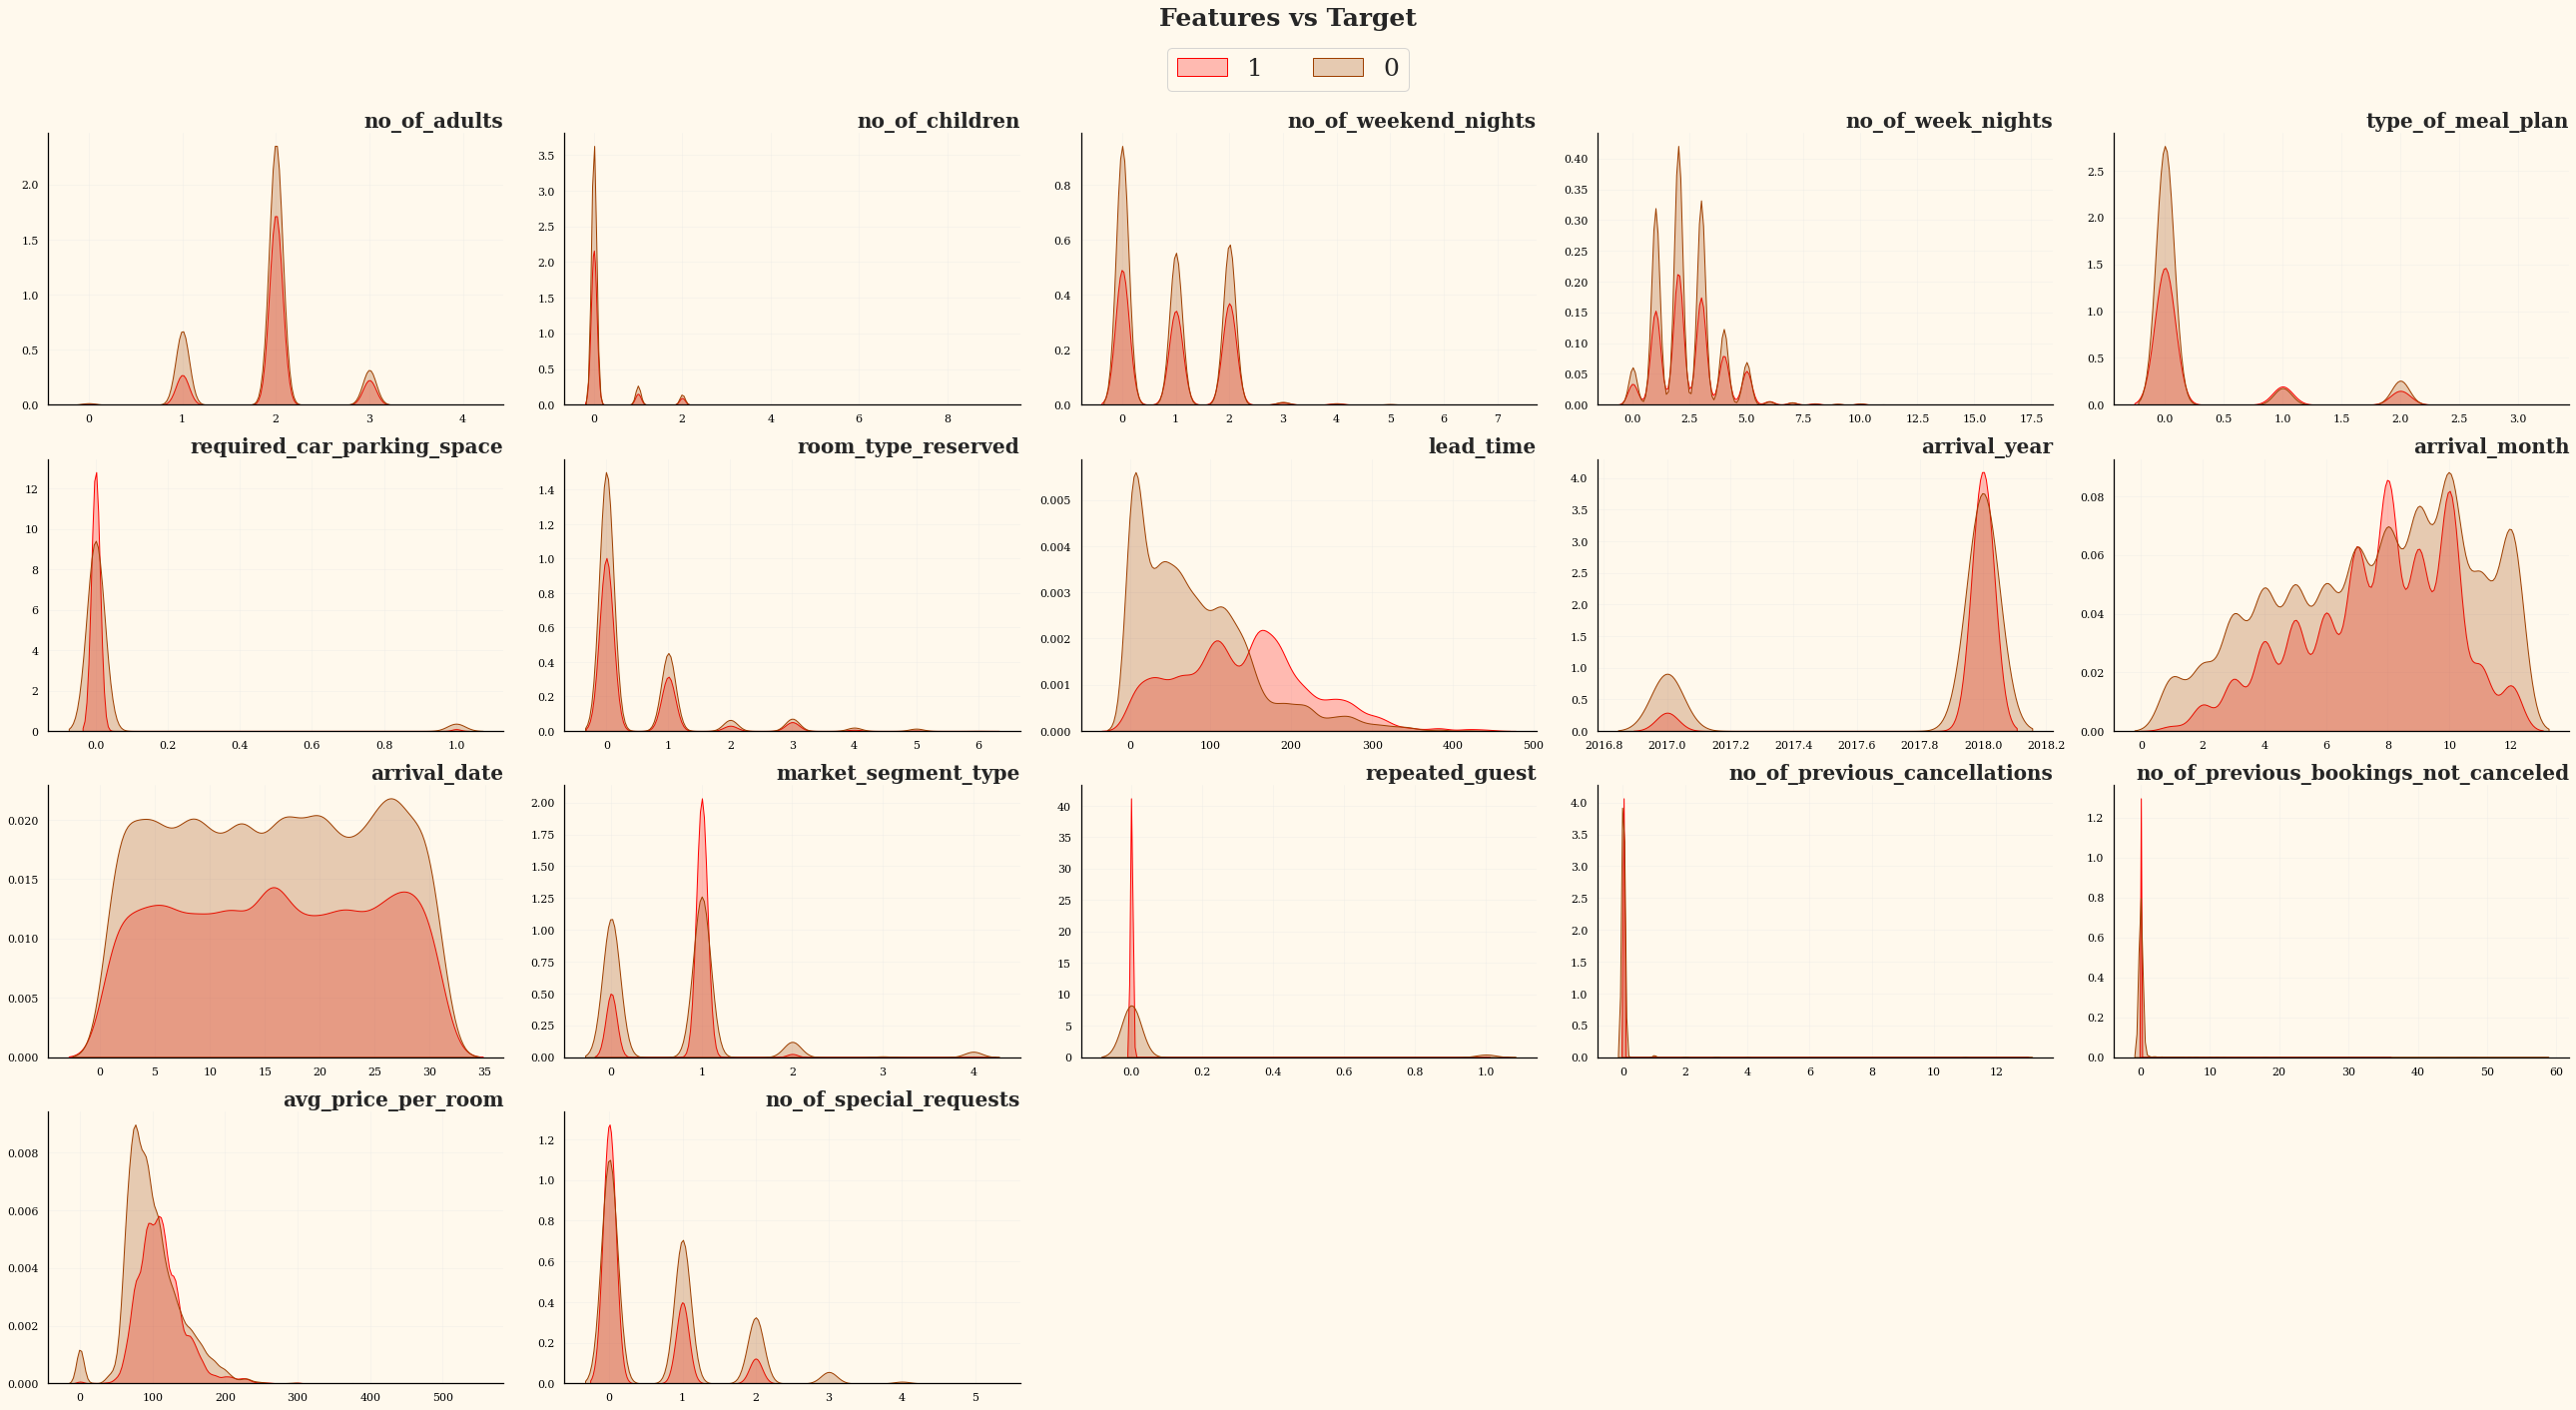

CPU times: user 8.22 s, sys: 9.92 s, total: 18.1 s
Wall time: 6.62 s


In [13]:
%%time
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(test.columns):
    ax = plt.subplot(4, 5, idx + 1)
    sns.kdeplot(
        data=train, hue='booking_status', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Correlations</p>

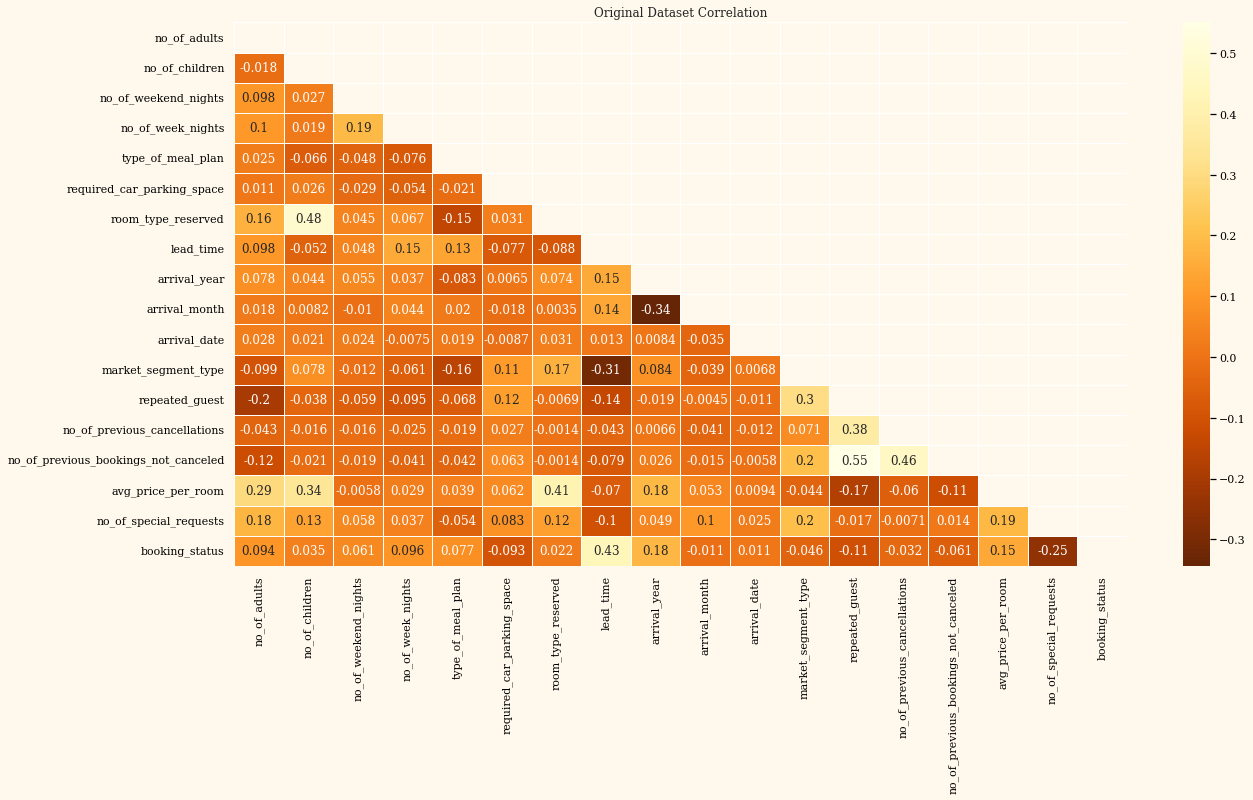

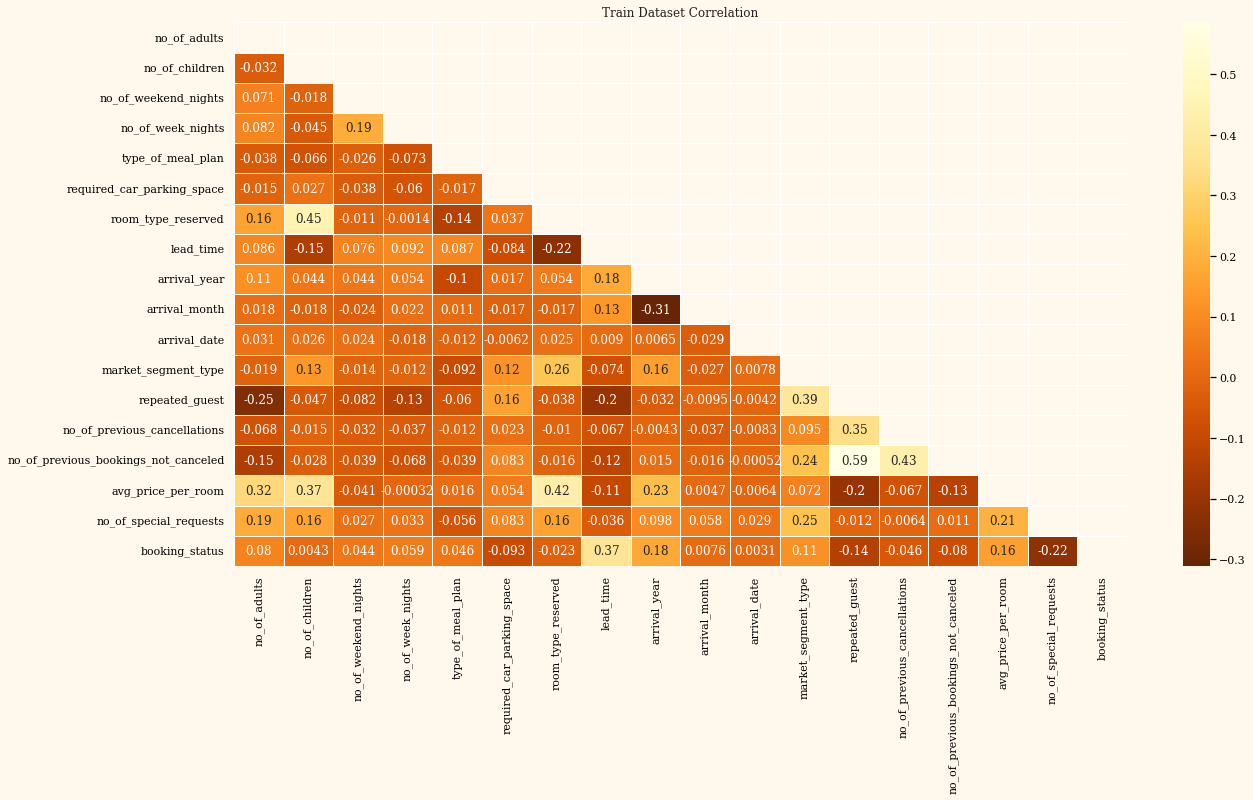

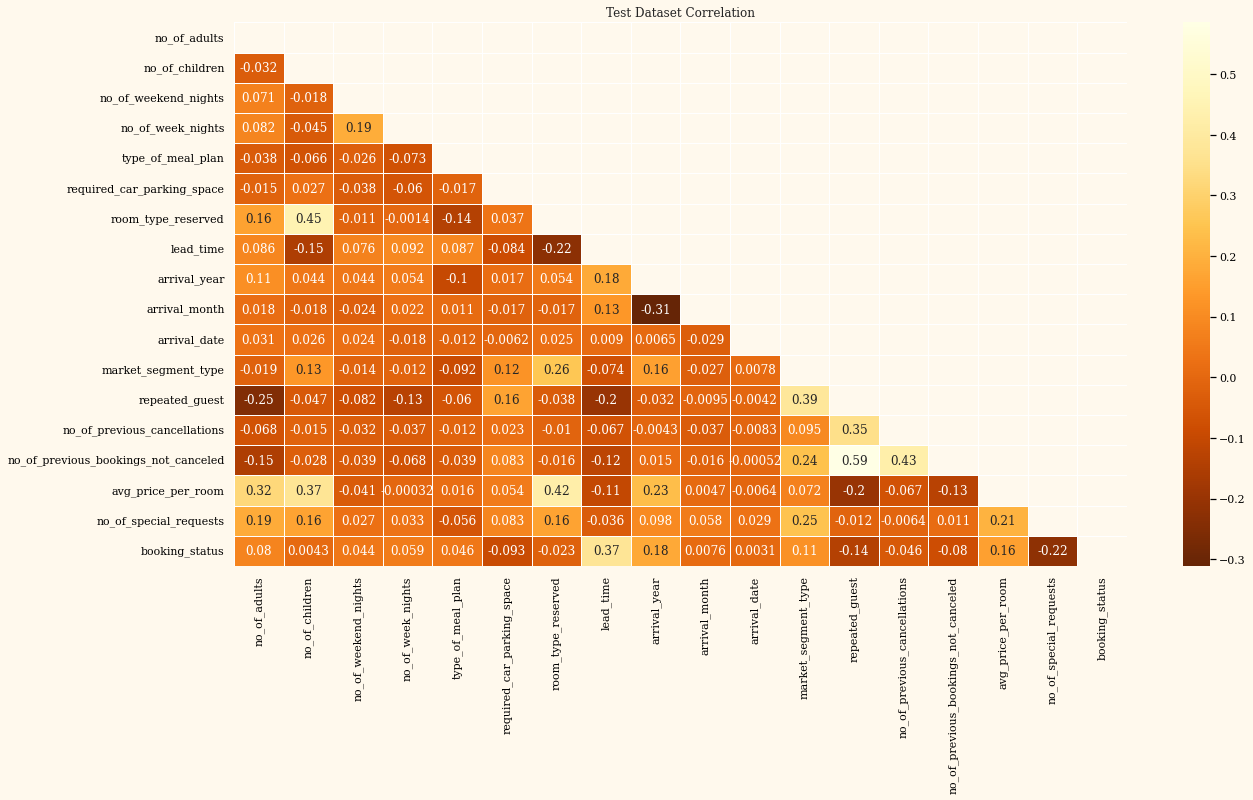

In [14]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(origin, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(train, 'Test Dataset Correlation')

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Feature Interaction based on `avg_price_per_room` example</p>

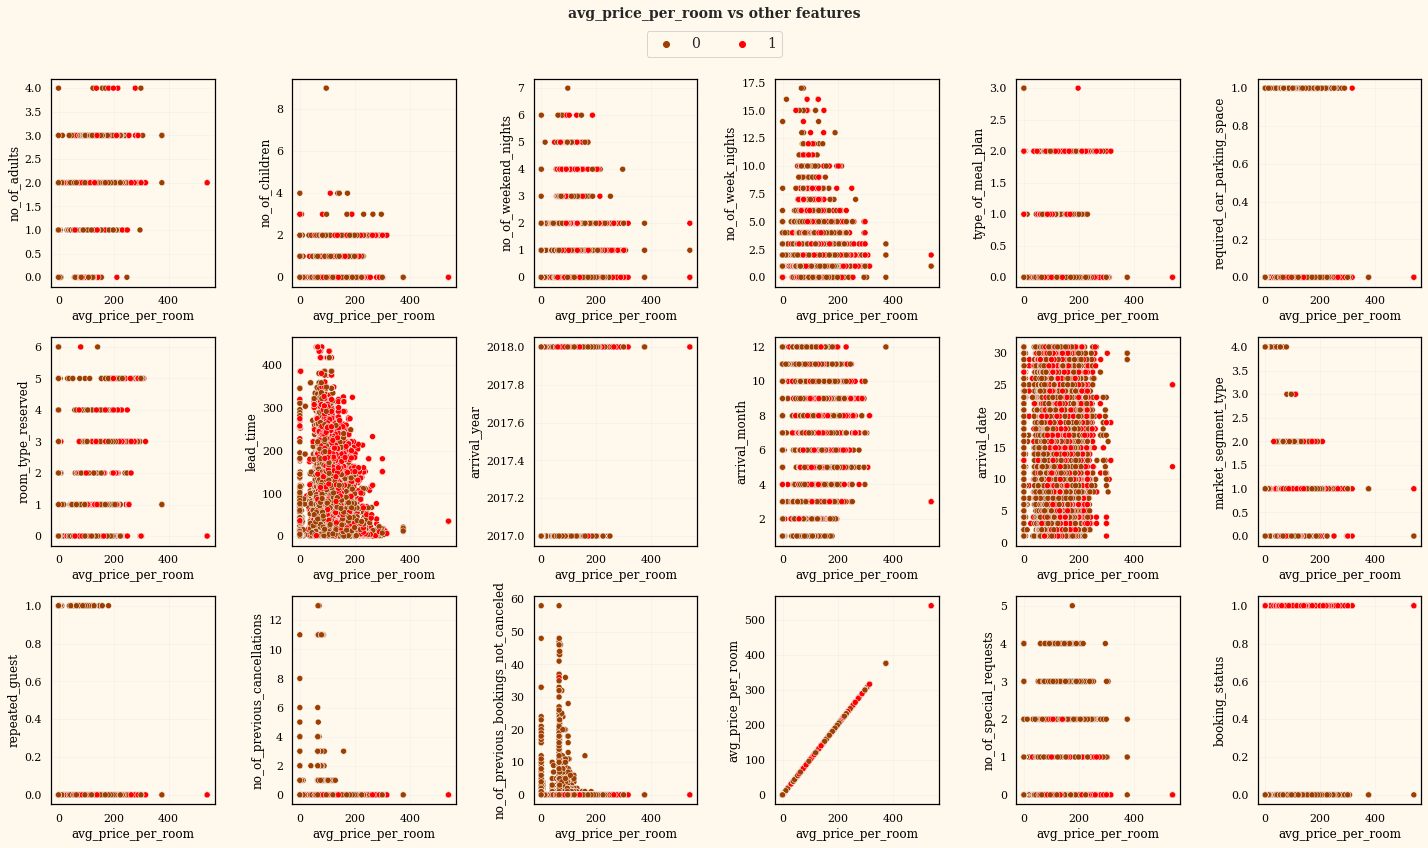

In [15]:
for col in ['avg_price_per_room']:
    fig, axes = plt.subplots(3, 6, figsize=(20, 4*3))
    for i, (ax, c) in enumerate(zip(axes.ravel(), train.columns)):
        sns.scatterplot(data=train, x=col, y=c, ax=ax, palette=['#9E3F00', 'red'],
                        hue='booking_status')
        ax.set(xlabel=col, ylabel=c)
        patches, legends = ax.get_legend_handles_labels()
        ax.legend().remove()
    fig.suptitle(f'avg_price_per_room vs other features\n\n\n', ha='center',  fontweight='bold', fontsize=14)
    fig.legend(patches, legends, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=14, ncol=2)
    plt.tight_layout()
    plt.show()

**Notes**:

`lead_time` and `avg_price_per_room` feature interaction looks interesting. Lots of cancellations happen when `lead_time` and `avg_price` are high. It sounds reasonable since people tend to do prelimary reservations beforehand and be picky of the pricey rooms. We might use this knowledge during the feature engineering.

p.s. You can make subplots for each feature by expanding the list.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Basic Feature Engineering</p>

**UPDATE**: I removed the engineered features which did not work well on the cv. You can uncomment them below if you want to proceed with them.

In [16]:
%%time
#############################################################################################
# CFG
#############################################################################################
SEED = 42
FOLDS = 30
ALPHA = 7
EXP_NUM = 1
SAVE = False
COMBINE = True

if COMBINE:
    train = pd.concat([train, origin]).reset_index(drop=True)
    
class BookingDataProcessor:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
    
    @staticmethod
    def fe(df):
        # Fix date anomalies (pd.to_datetime throws parsing error for some days, see anomalies section).
        df['year_month'] = pd.to_datetime(df[['arrival_year', 'arrival_month']].astype(str).sum(1), format='%Y%m')
        df.loc[df.arrival_date > df.year_month.dt.days_in_month, 'arrival_date'] = df.year_month.dt.days_in_month
        df.drop(columns='year_month', inplace=True)
        
#         # Creates date features.
#         df['arrival_full_date'] = (df['arrival_year'].astype(str) 
#                                    + '-' + df['arrival_month'].astype(str)
#                                    + '-' + df['arrival_date'].astype(str))
#         df['arrival_full_date'] = pd.to_datetime(df.arrival_full_date)
#         df['arrival_week'] = df['arrival_full_date'].dt.isocalendar().week.astype(float)
#         df['arrival_dayofweek'] = df['arrival_full_date'].dt.dayofweek
#         df['arrival_quarter'] = df['arrival_full_date'].dt.quarter
#         df['arrival_dayofyear'] = df['arrival_full_date'].dt.dayofyear
        
#         # Creates the season and holiday features. (also you can add holidays).
#         # ['winter', 'spring', 'summer', 'fall']
#         df['season'] = df.arrival_month%12 // 3 + 1
#         cal = USFederalHolidayCalendar()
#         holidays = cal.holidays(start='2017-01-01', end='2018-12-31')
#         df['is_holiday'] = 0
#         df.loc[df.arrival_full_date.isin(holidays), 'is_holiday'] = 1
        
#         # Aggregation by `season` as key and 'avg_price_per_room' as value (you can try quarters, months, etc).
#         aggr_df = df.groupby(by=key, sort=False)['avg_price_per_room'].agg(['mean', 'std', 'min', 'max', 'sum', 'last'])
#         aggr_df = aggr_df.add_prefix('avg_price_per_room_')
#         df = df.merge(aggr_df.reset_index(), on=key, how='left')
        
#         # Interaction between the correlated features and also lead time.
#         df['no_of_adults_div_price'] = df.no_of_adults / (df.avg_price_per_room + 1e-6)
#         df['no_of_children_div_price'] = df.no_of_children / (df.avg_price_per_room + 1e-6)
#         df['lead_time_div_price'] = df.lead_time / (df.avg_price_per_room + 1e-6)
#         df.drop(columns=['arrival_full_date'], inplace=True)
        return df

    def process_data(self):
        self.train_data = self.fe(self.train_data)
        self.test_data = self.fe(self.test_data)
        return self.train_data, self.test_data
    
f_e = BookingDataProcessor(train, test)
train, test = f_e.process_data()        

print(f'{gld}[INFO] Shapes after Feature Engineering Phase:'
      f'{gld}\n[+] train -> {red}{train.shape}'
      f'{gld}\n[+] test -> {red}{test.shape}\n')

[INFO] Shapes after Feature Engineering Phase:
[+] train -> (60237, 18)
[+] test -> (28068, 17)

CPU times: user 134 ms, sys: 4.74 ms, total: 138 ms
Wall time: 140 ms


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Base XGB Model</p>

In [17]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion_roc(oof: list) -> None:
    """Draws a confusion matrix and roc_curve with AUC score.
        
        Args:
            oof: predictions for each fold stacked. (list of tuples)
        
        Returns:
            None
    """
    
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    df.index = df.index.astype(int)
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color='#20BEFF', ax=ax[1])
    plt.tight_layout();
    
def get_mean_auc(oof: np.array):
    """oof: ['val_idx', 'preds', 'target']"""
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    mean_val_auc = roc_auc_score(oof.target, oof.preds)
    return mean_val_auc

In [18]:
xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['booking_status'] + ['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'])
y = train.booking_status
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # XGboost model and fit
    model = XGBClassifier(n_estimators=2000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
    model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=300, verbose=0)

    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = roc_auc_score(y_valid, val_preds)
    best_iter = model.best_iteration

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T # shape(len(val_idx), 3)
    f_imp.append({i: j for i in model.feature_names_in_ for j in model.feature_importances_ })
    print(f'{" "*20} auc:{blu}{val_score:.5f}{res} {" "*6} best iteration  :{blu}{best_iter}{res}')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
#     test_preds = model.predict_proba(test)[:,1] / FOLDS
#     predictions += test_preds
    if val_score > 0.917:
        test_preds = model.predict_proba(test.drop(columns=['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']))[:,1] 
        predictions += test_preds
        counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} AUC: {red}{mean_val_auc:.5f}{res}')

######################## Training FOLD 1 ########################
                     auc:0.92333        best iteration  :1323
                     auc:0.92521        best iteration  :692
                     auc:0.91941        best iteration  :975
                     auc:0.92155        best iteration  :880
######################## Training FOLD 5 ########################
                     auc:0.91259        best iteration  :1131
                     auc:0.90363        best iteration  :352
                     auc:0.91513        best iteration  :1092
                     auc:0.91232        best iteration  :688
                     auc:0.90961        best iteration  :716
######################## Training FOLD 10 ########################
                     auc:0.91327        best iteration  :465
                     auc:0.92046        best iteration  :654
                     auc:0.91483        best iteration  :594
                     auc:0.90246        best iteration  :848
     

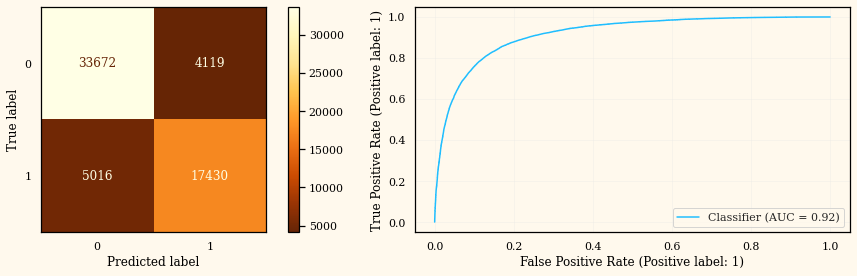

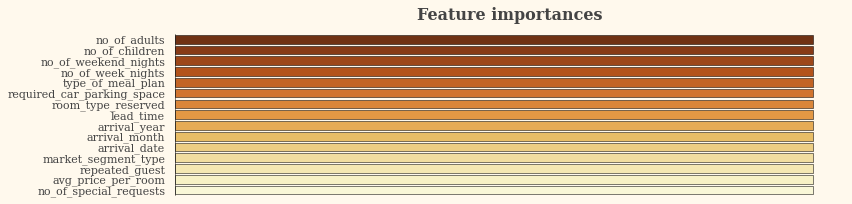

In [19]:
show_confusion_roc(xgb_oof)
f_imp_df = pd.DataFrame(f_imp).mean().reset_index()
f_imp_df.columns = ['feature', 'avg_imp']
f_importance_plot(f_imp_df)

<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Submission</p>

7.465943417743237e-08 0.9409803011838127


,id,booking_status
0,42100,0.17
1,42101,0.03
2,42102,0.24


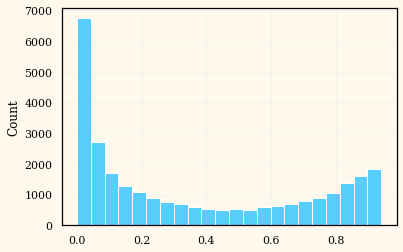

In [20]:
sns.histplot(predictions, color='#20BEFF');
print(predictions.min(), predictions.max())
sub = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
# sub_lgbm = pd.read_csv('/kaggle/input/s3e7-submissions/lgbm_base_no_threshold.csv')
# sub.booking_status = predictions * .51 + sub_lgbm.booking_status/10 * .49
# sub.to_csv('submission_blend_with_lgbm.csv', index=False)
sub.booking_status = predictions
sub.to_csv('submission_xgb_without_two_worst_ft.csv', index=False)
sub.head(3)

<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Data Leak</p>


[Discussion.](https://www.kaggle.com/competitions/playground-series-s3e7/discussion/388851) Kudos to @icfoer.

In [21]:
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')

y = 'booking_status'
dup_features = test.drop(columns='id').columns.tolist()
values_to_assign = test.merge(train.drop(columns='id'), on=dup_features, how='inner')[['id', y]]
map_di = {0: sub[y].max(), 1: sub[y].min()}
sub.loc[sub.id.isin(values_to_assign.id), y] = values_to_assign[y].map(map_di).values
sub.loc[sub.id.isin(values_to_assign.id), y]

sub.to_csv('submission_xgb_without_two_worst_ft_data_leak.csv', index=False)
sub.loc[sub.id.isin(values_to_assign.id)].head(10)

,id,booking_status
48,42148,0.00
92,42192,0.00
159,42259,0.00
300,42400,0.00
319,42419,0.00
346,42446,0.00
374,42474,0.94
429,42529,0.00
472,42572,0.94
537,42637,0.94


<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Acknowledgement</p>

@jcaliz for .css and plotting ideas.